In [1]:
"""
CS 484 Final Project

Alexander Wei, a6wei@uwaterloo.ca, 20836214
Kaiz Nanji, k4nanji@uwaterloo.ca 20873846

Project #5
Semi-supervised image classification: assuming that only M out of N images in the traingin data have ground truth labels,
design and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in
the training dataset(e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).You should
demonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one
basic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep
features (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss
enforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function
formulated in Bridle & MacKay "Unsupervised Classifiers, Mutual Information and Phantom Targets", NIPS 1991. 
"""

'\nCS 484 Final Project\n\nAlexander Wei, a6wei@uwaterloo.ca, 20836214\nKaiz Nanji, k4nanji@uwaterloo.ca 20873846\n\nProject #5\nSemi-supervised image classification: assuming that only M out of N images in the traingin data have ground truth labels,\ndesign and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in\nthe training dataset(e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).You should\ndemonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one\nbasic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep\nfeatures (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss\nenforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function\nformulated in Bridle & MacKay 

In [2]:
from src.encoder import *
from src.k_means import *
from src.loader import *
from src.utils import *

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [19]:
set_seed()

transform = get_transform()

class ClassificationNetwork:
    def __init__(self, labeled_percent):
        self.labeled_percent = labeled_percent
        self.labeled_train_loader, self.unlabeled_train_loader, self.val_loader = self.get_loaders()

    def get_loaders(self):
        # Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
        # When batch size changes, the learning rate may also need to be adjusted. 
        # Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
        TRAIN_BATCH_SIZE = 100

        # If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
        # but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
        NUM_WORKERS = 0

        dataset_handler = LabeledUnlabeledMNIST(self.labeled_percent)
        labeled_train = dataset_handler.labeled_dataset
        unlabeled_train = dataset_handler.unlabeled_dataset
        mnist_test = dataset_handler.mnist_test

        self.VALIDATION_SIZE = len(mnist_test)

        labeled_train_loader = DataLoader(labeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        unlabeled_train_loader = DataLoader(unlabeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        val_loader = DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=NUM_WORKERS, shuffle=False)

        return labeled_train_loader, unlabeled_train_loader, val_loader

    def train(self, epochs = 1):
        %run -i "run.py" encoder "{self.labeled_percent}" -t -e "{epochs}"

    def get_encodes_targets(self, loader, encoder_model):
        encodes = None
        targets = None

        with torch.no_grad():
            for batch_id, (data, target) in enumerate(loader):
                data = data.to(device)
                encoded = encoder_model.encode(data)

                if batch_id == 0:
                    encodes = encoded
                    targets = target
                else:
                    encodes = torch.cat((encodes, encoded))
                    targets = torch.cat((targets, target))
        
        return encodes, targets

    def run_kmeans(self):
        k_means = KMeansModel(tensor_dims=256)

        encoder_model = EncoderModel(device, None)
        encoder_model.load_state_dict(torch.load("./saves/encoder_model_{}.pth".format(str(self.labeled_percent)[2:])))
        encoder_model = encoder_model.to(device)

        encoder_model.train(False)

        labeled_encodes, labeled_targets = self.get_encodes_targets(self.labeled_train_loader, encoder_model)
        unlabeled_encodes, unlabeled_targets = self.get_encodes_targets(self.unlabeled_train_loader, encoder_model)

        k_means.fit(labeled_encodes, labeled_targets, unlabeled_encodes)
        
        val_data, val_labels = next(iter(self.val_loader))
        encoded_val_data = encoder_model.encode(val_data.to(device))

        predictions = k_means.predict(encoded_val_data)

        confusion_matrix = np.zeros((10, 10))
        for label, pred in zip(val_labels, predictions):
            confusion_matrix[label, pred] += 1

        accuracy = sum([confusion_matrix[i][i] for i in range(10)]) / self.VALIDATION_SIZE
        print(f"Accuracy: {accuracy * 100}%")

        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[i for i in range(10)])
        disp.plot()
        plt.title("K Means Classifier Confusion Matrix")
        plt.show()


### Note: Occcasionally training the autoencoder fails because the loss diverges. This doesn't happen often and just try running it again a few times.

cuda
Loss at epoch 0: 0.33078327775001526
Loss at epoch 1: 0.25613322854042053
Loss at epoch 2: 0.2271851897239685
Loss at epoch 3: 0.21551921963691711
Loss at epoch 4: 0.20352613925933838
Loss at epoch 5: 0.2002013474702835
Loss at epoch 6: 0.19272373616695404
Loss at epoch 7: 0.19393561780452728
Loss at epoch 8: 0.1861908733844757
Loss at epoch 9: 0.18460552394390106
Loss at epoch 10: 0.18744537234306335
Loss at epoch 11: 0.18187041580677032
Loss at epoch 12: 0.18052659928798676
Loss at epoch 13: 0.18156549334526062
Loss at epoch 14: 0.17954936623573303
Completed training! Final loss: 0.17954936623573303
Running validation...


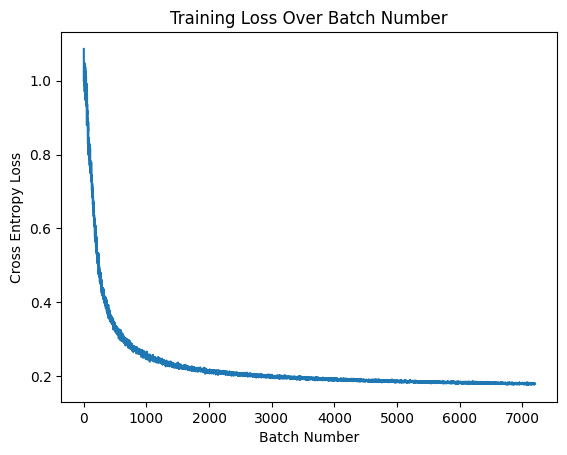

Saving model...
Accuracy: 61.050000000000004%


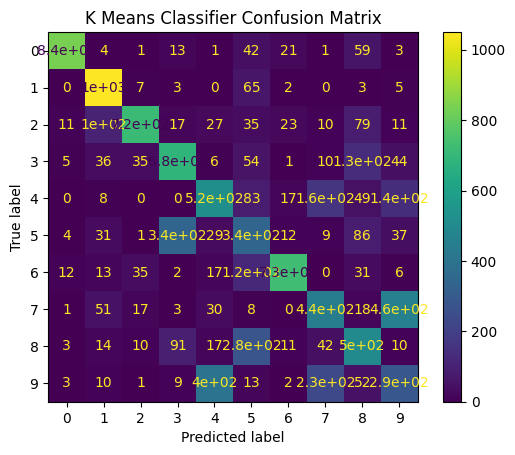

In [14]:
network = ClassificationNetwork(0.8)
network.train(epochs=15)
network.run_kmeans()

cuda
Loss at epoch 0: 0.4216350317001343
Loss at epoch 1: 0.3064698278903961
Loss at epoch 2: 0.2693001329898834
Loss at epoch 3: 0.2485009729862213
Loss at epoch 4: 0.22686856985092163
Loss at epoch 5: 0.22027264535427094
Loss at epoch 6: 0.21025273203849792
Loss at epoch 7: 0.2037840634584427
Loss at epoch 8: 0.20196060836315155
Loss at epoch 9: 0.20032082498073578
Loss at epoch 10: 0.1995336264371872
Loss at epoch 11: 0.19533608853816986
Loss at epoch 12: 0.19145740568637848
Loss at epoch 13: 0.18945209681987762
Loss at epoch 14: 0.1921209692955017
Completed training! Final loss: 0.1921209692955017
Running validation...


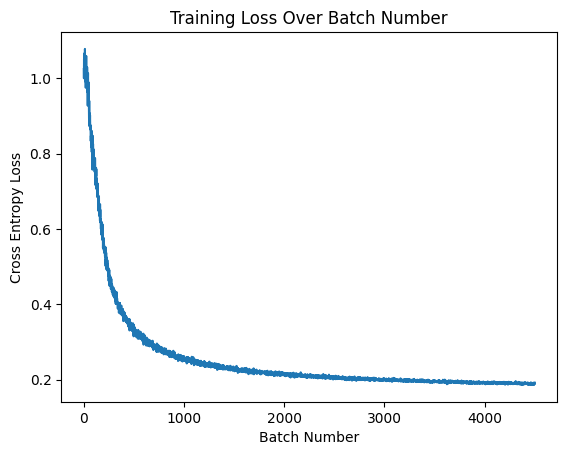

Saving model...
Accuracy: 56.489999999999995%


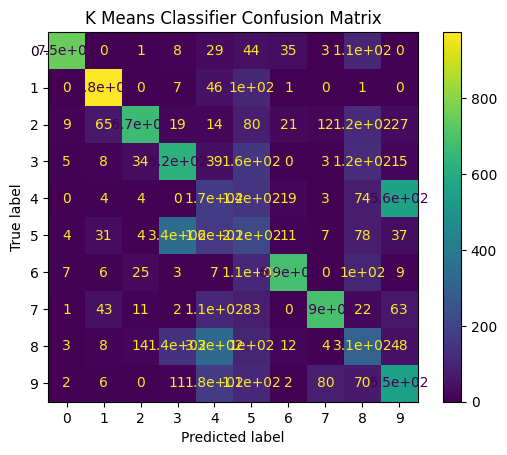

In [15]:
network = ClassificationNetwork(0.5)
network.train(epochs=15)
network.run_kmeans()

cuda
Loss at epoch 0: 0.7531043887138367
Loss at epoch 1: 0.48412761092185974
Loss at epoch 2: 0.38797080516815186
Loss at epoch 3: 0.3473700284957886
Loss at epoch 4: 0.2996198832988739
Loss at epoch 5: 0.28897392749786377
Loss at epoch 6: 0.266388475894928
Loss at epoch 7: 0.25623539090156555
Loss at epoch 8: 0.2511814832687378
Loss at epoch 9: 0.24227842688560486
Loss at epoch 10: 0.23347750306129456
Loss at epoch 11: 0.2313872128725052
Loss at epoch 12: 0.2258356362581253
Loss at epoch 13: 0.22365590929985046
Loss at epoch 14: 0.22011156380176544
Completed training! Final loss: 0.22011156380176544
Running validation...


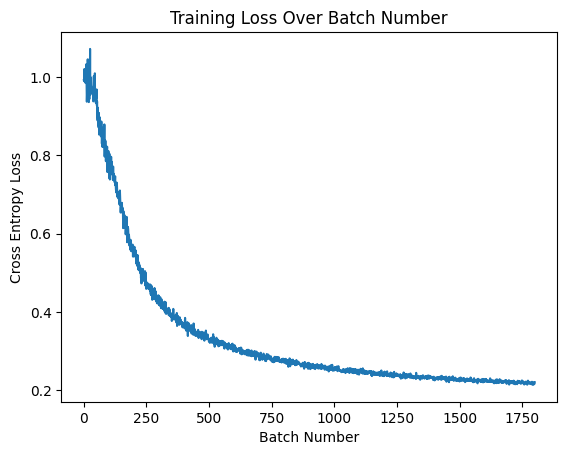

Saving model...
Accuracy: 54.72%


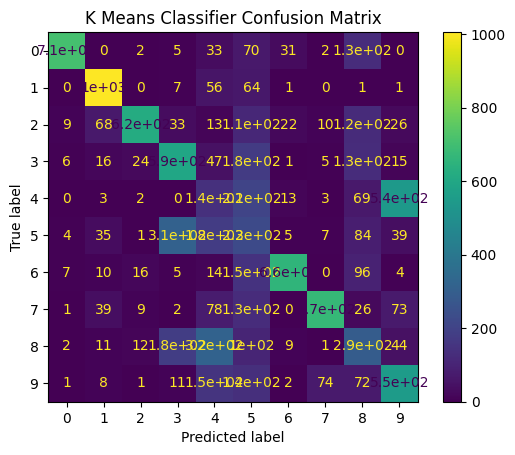

In [16]:
network = ClassificationNetwork(0.2)
network.train(epochs=20)
network.run_kmeans()

cuda
Loss at epoch 0: 1.0189646482467651
Loss at epoch 1: 1.0140258073806763
Loss at epoch 2: 0.9849298596382141
Loss at epoch 3: 0.9762744903564453
Loss at epoch 4: 1.0400704145431519
Loss at epoch 5: 0.9492045044898987
Loss at epoch 6: 0.9286838173866272
Loss at epoch 7: 0.9417294263839722
Loss at epoch 8: 0.9226179718971252
Loss at epoch 9: 0.8681106567382812
Loss at epoch 10: 0.8793307542800903
Loss at epoch 11: 0.8565813302993774
Loss at epoch 12: 0.8507406115531921
Loss at epoch 13: 0.7940584421157837
Loss at epoch 14: 0.8112730383872986
Loss at epoch 15: 0.7898457646369934
Loss at epoch 16: 0.7660142183303833
Loss at epoch 17: 0.7898831367492676
Loss at epoch 18: 0.7458274960517883
Loss at epoch 19: 0.7397570610046387
Loss at epoch 20: 0.7411968111991882
Loss at epoch 21: 0.6922668218612671
Loss at epoch 22: 0.7022867798805237
Loss at epoch 23: 0.6608670353889465
Loss at epoch 24: 0.6280105710029602
Loss at epoch 25: 0.6438851356506348
Loss at epoch 26: 0.6259232759475708
Loss a

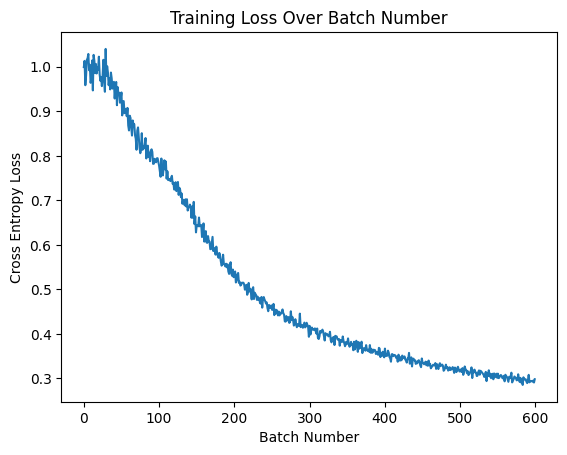

Saving model...
Accuracy: 52.65%


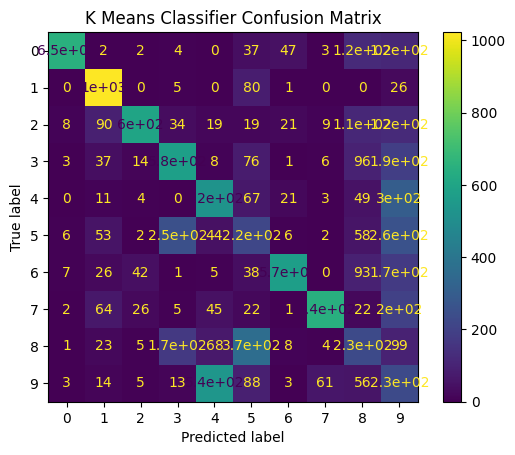

In [21]:
network = ClassificationNetwork(0.01)
network.train(epochs=100)
network.run_kmeans()

In [ ]:
# # Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# # When batch size changes, the learning rate may also need to be adjusted. 
# # Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
# TRAIN_BATCH_SIZE = 100

# # If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# # but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
# NUM_WORKERS = 0


# labeled_train_loader = DataLoader(labeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
# unlabeled_train_loader = DataLoader(unlabeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
# val_loader = DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=NUM_WORKERS, shuffle=False)

In [ ]:
# # Dimension of encoder output is N * 64 * 2 * 2 = 256

# k_means = KMeansModel(tensor_dims=256)

# encoder_model = EncoderModel(device, None)
# encoder_model.load_state_dict(torch.load("./saves/encoder_model_8.pth"))
# encoder_model = encoder_model.to(device)

In [ ]:
# encoder_model.train(False)

# labeled_encodes = None
# labeled_targets = None

# with torch.no_grad():
#   for batch_id, (data, target) in enumerate(labeled_train_loader):
    
#     data = data.to(device)

#     encoded = encoder_model.encode(data)

#     if batch_id == 0:
#       labeled_encodes = encoded
#       labeled_targets = target
#     else:
#       labeled_encodes = torch.cat((labeled_encodes, encoded))
#       labeled_targets = torch.cat((labeled_targets, target))

# print(labeled_targets)

tensor([5, 0, 5,  ..., 3, 0, 8])


In [ ]:
# unlabeled_encodes = None
# unlabeled_targets = None

# with torch.no_grad():
#   for batch_id, (data, target) in enumerate(unlabeled_train_loader):
    
#     data = data.to(device)

#     encoded = encoder_model.encode(data)

#     if batch_id == 0:
#       unlabeled_encodes = encoded
#       unlabeled_targets = target
#     else:
#       unlabeled_encodes = torch.cat((unlabeled_encodes, encoded))
#       unlabeled_targets = torch.cat((unlabeled_targets, target))

# print(unlabeled_targets.shape)

torch.Size([12000])


In [ ]:
# k_means.fit(labeled_encodes, labeled_targets, unlabeled_encodes)

Accuracy: 62.470000000000006%


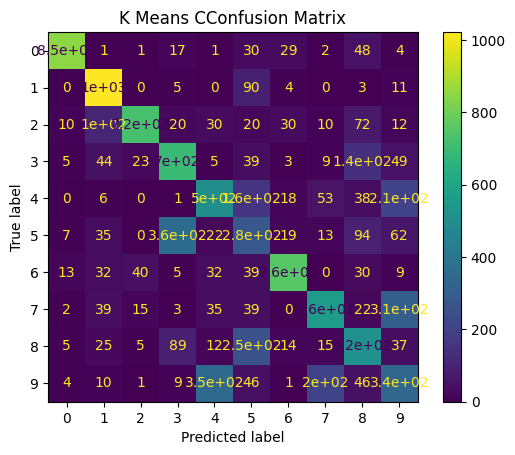

In [ ]:
# VALIDATION_SIZE = len(mnist_test)

# val_data, val_labels = next(iter(val_loader))
# encoded_val_data = encoder_model.encode(val_data.to(device))

# predictions = k_means.predict(encoded_val_data)

# confusion_matrix = np.zeros((10, 10))
# for label, pred in zip(val_labels, predictions):
#   confusion_matrix[label, pred] += 1

# accuracy = sum([confusion_matrix[i][i] for i in range(10)]) / VALIDATION_SIZE
# print(f"Accuracy: {accuracy * 100}%")

# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[i for i in range(10)])
# disp.plot()
# plt.title("K Means Classifier Confusion Matrix")
# plt.show()